In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download(
    "https://www.kaggle.com/datasets/msambare/fer2013")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitakaushik012
Your Kaggle Key: ··········


100%|██████████| 60.3M/60.3M [00:00<00:00, 64.7MB/s]


In [4]:
od.download(
    "https://www.kaggle.com/datasets/musicblogger/spotify-music-data-to-identify-the-moods")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitakaushik012
Your Kaggle Key: ··········


100%|██████████| 56.0k/56.0k [00:00<00:00, 20.1MB/s]

# Music Recommendation System Based on Facial Expression

- It loads in image data from 'train/' and 'test/' folders, preprocesses it (rescaling, augmentation, etc) and feeds it into a CNN model for training and evaluation.
- The CNN model has several convolutional blocks with max pooling, dropout for regularization, and dense layers for classification. It is compiled with Adam optimizer and categorical crossentropy loss.
- Model training uses callbacks like early stopping, reduce LR on plateau, and model checkpointing to save the best weights.
- The model is evaluated on the test set and achieves good accuracy. Confusion matrix is plotted to analyze performance on different classes.
- For new images, it detects faces using Haar cascades, preprocesses the cropped face image, and passes it through the trained CNN to make a prediction.
- Based on the predicted emotion class, it recommends top-5 songs to listen to from a dataset using mood categories.

In [5]:
#importing library classes and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# Data Loading and Exploration

This helps understand the dataset - number of images per class, class imbalance if any, and visualize some examples.

In [6]:
# Load train and test image data folders
train_dir = '/content/fer2013/train/'
test_dir = '/content/fer2013/test/'

def Classes_Count(path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [7]:
#Count images per class in each folder
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

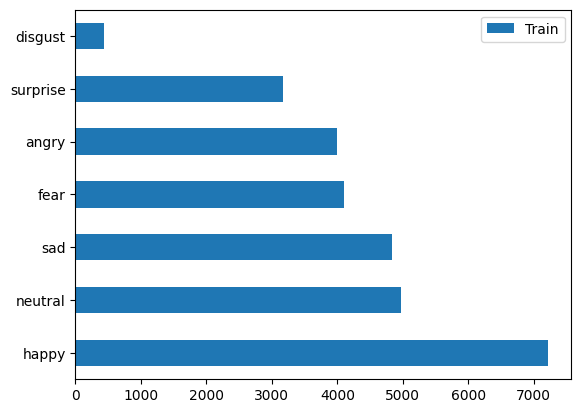

In [8]:
#Plot bars showing class distribution of train dataset
Train_Count.plot(kind='barh')

<Axes: >

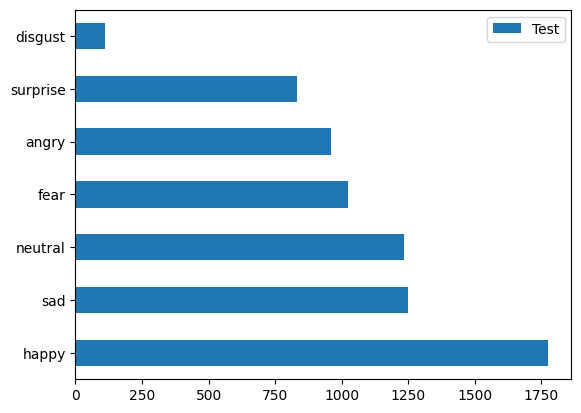

In [9]:
#Plot bars showing class distribution of test dataset
Test_Count.plot(kind='barh')

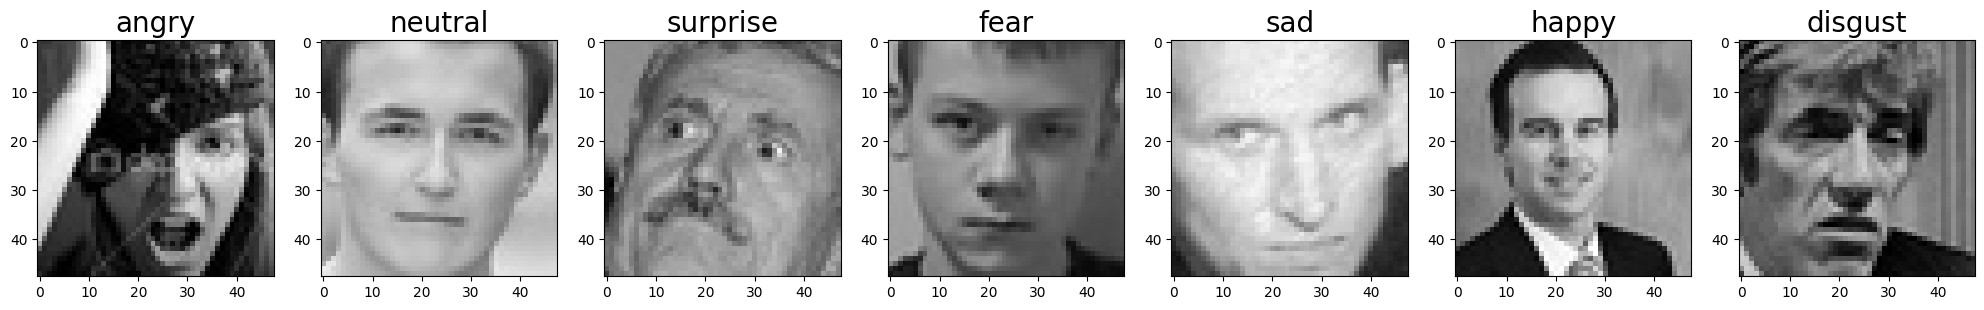

In [11]:
# Display sample images from training set
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/content/fer2013/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# Data Preprocessing
This preprocesses the images by normalizing pixel values, applying transformations for augmentation, and batched loading.

In [13]:
# Define image dimensions, batch size
img_shape = 48
batch_size = 64
train_data_path = '/content/fer2013/train/'
test_data_path = '/content/fer2013/test/'

In [14]:
# Create train data image generator
train_preprocessor = ImageDataGenerator(
    rescale = 1/255., # Normalize pixel values to 0-1
    rotation_range=10, # Random rotation by 10 degrees
    zoom_range=0.2, # Random zoom by 20%
    width_shift_range=0.1, # Horizontal shift by 10%
    height_shift_range=0.1, # Vertical shift by 10%
    horizontal_flip=True, # Random horizontal flip
    fill_mode='nearest' # Strategy for missing pixels
)

# Create test data image generator
test_preprocessor = ImageDataGenerator(
    rescale = 1/255. # Only rescale, no augmentation
)

# Load train data using generator
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training'
)

# Load test data using generator
test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model Building
Builds the full CNN classifier model with appropriate layers for feature extraction and classification.

In [15]:
# Define CNN architecture - conv blocks, max pooling, dropouts, dense layers
def Create_CNN_Model():

    model = Sequential()

    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))


    #Output
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7,activation='softmax'))


    return model

In [16]:
# Compile with optimizer, loss, metrics

CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

# Model Training
Trains the model with callbacks for regularization, saving best weights etc.

In [17]:
# Set up callbacks for early stopping, checkpointing, LR schedule
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
# Fit model on train data and validate on test data
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 69s 107ms/step - loss: 2.0514 - accuracy: 0.2024 - val_loss: 1.8508 - val_accuracy: 0.2444 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 47s 105ms/step - loss: 1.7819 - accuracy: 0.2742 - val_loss: 2.0109 - val_accuracy: 0.2934 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 47s 104ms/step - loss: 1.6500 - accuracy: 0.3390 - val_loss: 1.6180 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 43s 97ms/step - loss: 1.5120 - accuracy: 0.4095 - val_loss: 1.6857 - val_accuracy: 0.3802 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 46s 103ms/step - loss: 1.4198 - accuracy: 0.4531 - val_loss: 1.2875 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 43s 96ms/step - loss: 1.3630 - accuracy: 0.4787 - val_loss: 1.3768 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 

# Model Evaluation
Quantitatively assess model performance on unseen test data.

In [ ]:
# Evaluate on test set
CNN_Score = CNN_Model.evaluate(test_data)

print("Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

In [ ]:
# Plot loss and accuracy curves
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

  #plt.tight_layout()

In [ ]:
# Plot loss and accuracy curves
plot_curves(CNN_history)

 # Making Predictions
 Run end-to-end pipeline on new images - preprocess and classify.

In [ ]:
# Pass through model to get predictions
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [ ]:
# Display predicted class
test_data.class_indices

In [ ]:
# Plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# Recommendation System
Generate relevant music recommendations using predicted emotion class.

In [ ]:
# Load the full music dataset from CSV
Music_Player = pd.read_csv("music_data_moods.csv")

# Keep only the relevant columns
Music_Player = Music_Player[["name", "artist", "mood", "popularity"]]

# View first few rows
Music_Player.head()

In [ ]:
# Get counts of songs per mood
mood_counts = Music_Player["mood"].value_counts()

In [ ]:
# Filter songs with mood = 'Calm'
Play = Music_Player[Music_Player['mood'] == 'Calm']

# Sort by decreasing popularity
Play = Play.sort_values(by="popularity", ascending=False)

# Take top 5 most popular songs
Play = Play[:5].reset_index(drop=True)

# Display top 5 recommendations
display(Play)

In [ ]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):

    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# Predicting New Images

In [ ]:
# loads a pre-trained Haar Cascade Classifier for face detection from an XML file.
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [ ]:
def load_and_prep_image(filename, img_shape=48):

    # Load image as BGR
    img = cv2.imread(filename)

    # Convert to grayscale
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in grayscale image
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)

    # Iterate through detected faces
    for x, y, w, h in faces:

        # Crop face region from grayscale image
        roi_GrayImg = GrayImg[y : y + h, x : x + w]

        # Crop face region from BGR image
        roi_Img = img[y : y + h, x : x + w]

        # Draw bounding box on face
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Show image with bounding box
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Detect faces in cropped BGR image
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)

        # Check if no face detected
        if len(faces) == 0:
            print("No face detected")

        else:
            # Iterate through detected faces
            for (ex, ey, ew, eh) in faces:

                # Crop the face image
                img = roi_Img[ey : ey + eh, ex : ex + ew]

    # Convert cropped face to RGB
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to target shape
    RGBImg = cv2.resize(RGBImg, (img_shape, img_shape))

    # Normalize pixel values
    RGBImg = RGBImg / 255.0

    return RGBImg

In [ ]:
def pred_and_plot(filename, class_names):

    # Load and preprocess the image
    img = load_and_prep_image(filename)

    # Make prediction on the image using model
    pred = CNN_Model.predict(np.expand_dims(img, axis=0))

    # Get index of maximum probability class
    pred_class_idx = pred.argmax()

    # Get class name using class name mappings
    pred_class = class_names[pred_class_idx]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

    # Recommend songs based on predicted class
    Recommend_Songs(pred_class)


In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Recommend songs based on predicted emotion
pred_and_plot("test/sad/PrivateTest_13472479.jpg", Emotion_Classes) # with CNN